## Retrieve data

In [1]:
import os
from collections import Counter
from tqdm import tqdm


data_dir = "/media/aziz/Data/Aziz/data/gans_for_apr/"

# Collect paths to files
file_paths = [root+'/'+name for root, dirs, files in tqdm(os.walk(data_dir)) for name in files]
buggy_paths, fixed_paths = [], []
buggy_paths = [f_path for f_path in tqdm(file_paths) if 'buggy' in f_path]
fixed_paths = [f_path for f_path in tqdm(file_paths) if 'fixed' in f_path]

# Collect file contents
buggy_data = []
for path in tqdm(buggy_paths):
    with open(path, 'r', encoding='utf-8') as f:
        buggy_data.append(f.read())
fixed_data = []
for path in tqdm(fixed_paths):
    with open(path, 'r', encoding='utf-8') as f:
        fixed_data.append(f.read())

print('Number of processed files:-')
print(len(buggy_data), 'buggy files +', len(fixed_data), 'fixed files = ', len(buggy_data)+len(fixed_data), 'files')

20828it [00:00, 66898.01it/s]
100%|██████████| 20826/20826 [00:00<00:00, 58116.40it/s]

Number of processed files:-
20826 buggy files + 20826 fixed files =  41652 files


## Clean data - Reduce noise

### Remove comments

In [2]:
import re


def remove_comments(code):
    code = re.sub('(?s)/\*.*?\*/', '', code)
    return re.sub('(//[^\n]*)', '', code)


buggy_no_comments = [remove_comments(x) for x in tqdm(buggy_data)]
fixed_no_comments = [remove_comments(x) for x in tqdm(fixed_data)]
print('Comments have been removed')

100%|██████████| 20826/20826 [00:00<00:00, 117088.94it/s]

Comments have been removed


### Remove unnecessary white spaces

In [3]:
def remove_spaces(code):
    '''This function removes excessive spaces and keeps necessary ones'''
    code = code.splitlines()
    result = []
    for line in code:
        line = line.split()
        line = ' '.join(line)
        if len(line) > 0:  # Remove empty lines
            result.append(line)
    
    return '\n'.join(result)


buggy_no_spaces = [remove_spaces(x) for x in tqdm(buggy_no_comments)]
fixed_no_spaces = [remove_spaces(x) for x in tqdm(fixed_no_comments)]
print('White spaces have been removed')

100%|██████████| 20826/20826 [00:00<00:00, 30250.55it/s]

White spaces have been removed


### Remove identical buggy and fixed codes

In [4]:
buggy_texts, fixed_texts = [], []
for buggy, fixed in zip(buggy_no_spaces, fixed_no_spaces):
    if buggy != fixed:
        buggy_texts.append(buggy)
        fixed_texts.append(fixed)
print(len(buggy_no_spaces)-len(buggy_texts), 'code pairs have been removed')
print('Current # data points:', len(buggy_texts))

4514 code pairs have been removed
Current # data points: 16312


### Remove duplicated pairs in the dataset

In [5]:
text_pairs = [(x, y) for x, y in zip(buggy_texts, fixed_texts)]
code_pairs = sorted(set(text_pairs))

buggy_codes = [x[0] for x in code_pairs]
fixed_codes = [x[1] for x in code_pairs]

print(len(text_pairs)-len(code_pairs), 'code pairs have been removed')
print('Current # data points:', len(buggy_codes))

3663 code pairs have been removed
Current # data points: 12649


## Calculate Diffs

In [6]:
from difflib import ndiff


initial_diffs = [list(ndiff(x.splitlines(), y.splitlines())) for x, y in tqdm(zip(buggy_codes, fixed_codes))]

12649it [00:03, 3905.59it/s]


### Restrict to one-line difference

In [7]:
one_line_diffs = []
for diff in tqdm(initial_diffs):
    if sum([1 for x in diff if x.startswith('-')]) > 1 or sum([1 for x in diff if x.startswith('+')]) > 1:
        continue
    one_line_diffs.append(diff)

print(len(initial_diffs)-len(one_line_diffs), 'code pairs have been removed')
print('Current # data points:', len(one_line_diffs))

100%|██████████| 12649/12649 [00:00<00:00, 68385.77it/s]

309 code pairs have been removed
Current # data points: 12340


### Restrict to modified lines (exclude added/deleted lines)

In [8]:
diffs = []
for diff in tqdm(one_line_diffs):
    for i, x in enumerate(diff):
        if x.startswith('+') and diff[i-1].startswith('-'):
            diffs.append((diff[i-1][2:], x[2:]))

print(len(one_line_diffs)-len(diffs), 'code pairs have been removed')
print('Current # data points:', len(diffs))

100%|██████████| 12340/12340 [00:00<00:00, 73904.96it/s]

6813 code pairs have been removed
Current # data points: 5527


#### Shuffle and keep only 5 data points

In [9]:
from random import seed, sample


seed(30)
shuf_diffs = sample(diffs, k=len(diffs))
final_diffs = shuf_diffs[:5]

buggy_data = [x[0] for x in final_diffs]
fixed_data = [x[1] for x in final_diffs]


# with open('buggy_data.txt', "w", encoding='utf-8') as file:
#     for bug in buggy_data:
#         file.write(bug+'\n')
# with open('fixed_data.txt', "w", encoding='utf-8') as file:
#     for fix in fixed_data:
#         file.write(fix+'\n')
# print('Dataset has been written to disk')

# The Experiment

In [10]:
# with open('buggy_data.txt', 'r', encoding='utf-8') as f:
#     buggy_data = f.read().split("\n")
# with open('fixed_data.txt', 'r', encoding='utf-8') as f:
#     fixed_data = f.read().split("\n")
# buggy_data = buggy_data[:-1]
# fixed_data = fixed_data[:-1]

buggy_codes = [list(x) for x in buggy_data]
fixed_codes = [['<soc>']+list(x)+['<eoc>'] for x in fixed_data]

In [11]:
print("Before vectorisation:-")
print(buggy_data[2])
print(fixed_data[2])
print("====================")
print("After vectorisation:-")
print(buggy_codes[2])
print(fixed_codes[2])

Before vectorisation:-
dest = _dpMgr.planDeployment(vmProfile, plan, exclude);
dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
After vectorisation:-
['d', 'e', 's', 't', ' ', '=', ' ', '_', 'd', 'p', 'M', 'g', 'r', '.', 'p', 'l', 'a', 'n', 'D', 'e', 'p', 'l', 'o', 'y', 'm', 'e', 'n', 't', '(', 'v', 'm', 'P', 'r', 'o', 'f', 'i', 'l', 'e', ',', ' ', 'p', 'l', 'a', 'n', ',', ' ', 'e', 'x', 'c', 'l', 'u', 'd', 'e', ')', ';']
['<soc>', 'd', 'e', 's', 't', ' ', '=', ' ', '_', 'd', 'p', 'M', 'g', 'r', '.', 'p', 'l', 'a', 'n', 'D', 'e', 'p', 'l', 'o', 'y', 'm', 'e', 'n', 't', '(', 'v', 'm', 'P', 'r', 'o', 'f', 'i', 'l', 'e', ',', ' ', 'p', 'l', 'a', 'n', ',', ' ', 'e', 'x', 'c', 'l', 'u', 'd', 'e', ',', ' ', 'n', 'u', 'l', 'l', ')', ';', '<eoc>']


In [12]:
vocab = set([x for y in buggy_codes for x in y]+[x for y in fixed_codes for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [13]:
print(int_token_map)

{1: '.', 2: 'l', 3: 'q', 4: 'h', 5: '!', 6: 'M', 7: ';', 8: '0', 9: 'o', 10: '<eoc>', 11: 'v', 12: 'E', 13: 'T', 14: 'p', 15: '3', 16: 'k', 17: 'd', 18: 'e', 19: 'G', 20: '=', 21: 'J', 22: 'D', 23: 'y', 24: 'O', 25: '(', 26: 'x', 27: 'r', 28: '<soc>', 29: 't', 30: 'L', 31: 'P', 32: ',', 33: 's', 34: 'i', 35: 'c', 36: '1', 37: '6', 38: ' ', 39: 'n', 40: '_', 41: 'S', 42: ')', 43: '&', 44: '+', 45: '|', 46: 'g', 47: 'm', 48: 'u', 49: 'w', 50: 'f', 51: '{', 52: 'z', 53: 'a', 54: '-', 55: '"', 56: 'b', 0: '<pad/unknown>'}


In [14]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in buggy_codes])
max_fixed_len = max([len(txt) for txt in fixed_codes])
num_dps = len(fixed_codes)

In [15]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 5
Vocabulary size: 57
Max length in buggy codes: 68
Max length in fixed codes: 123


In [16]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(buggy_codes, fixed_codes)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.

In [17]:
from keras.layers import Input, Embedding, LSTM, Dense, dot, Activation, concatenate
from keras.models import Model


def build_lstm_encoder_decoder(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension,  mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build & compile model
    enc_dec = Model([buggy_input_layer, fixed_input_layer], model_output)
    enc_dec.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    
    return enc_dec

Using TensorFlow backend.


W0922 22:55:44.894326 140034647680768 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 22:55:44.904211 140034647680768 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 22:55:44.906591 140034647680768 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 22:55:45.746688 140034647680768 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please us

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 68, 1024)     58368       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 123, 1024)    58368       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

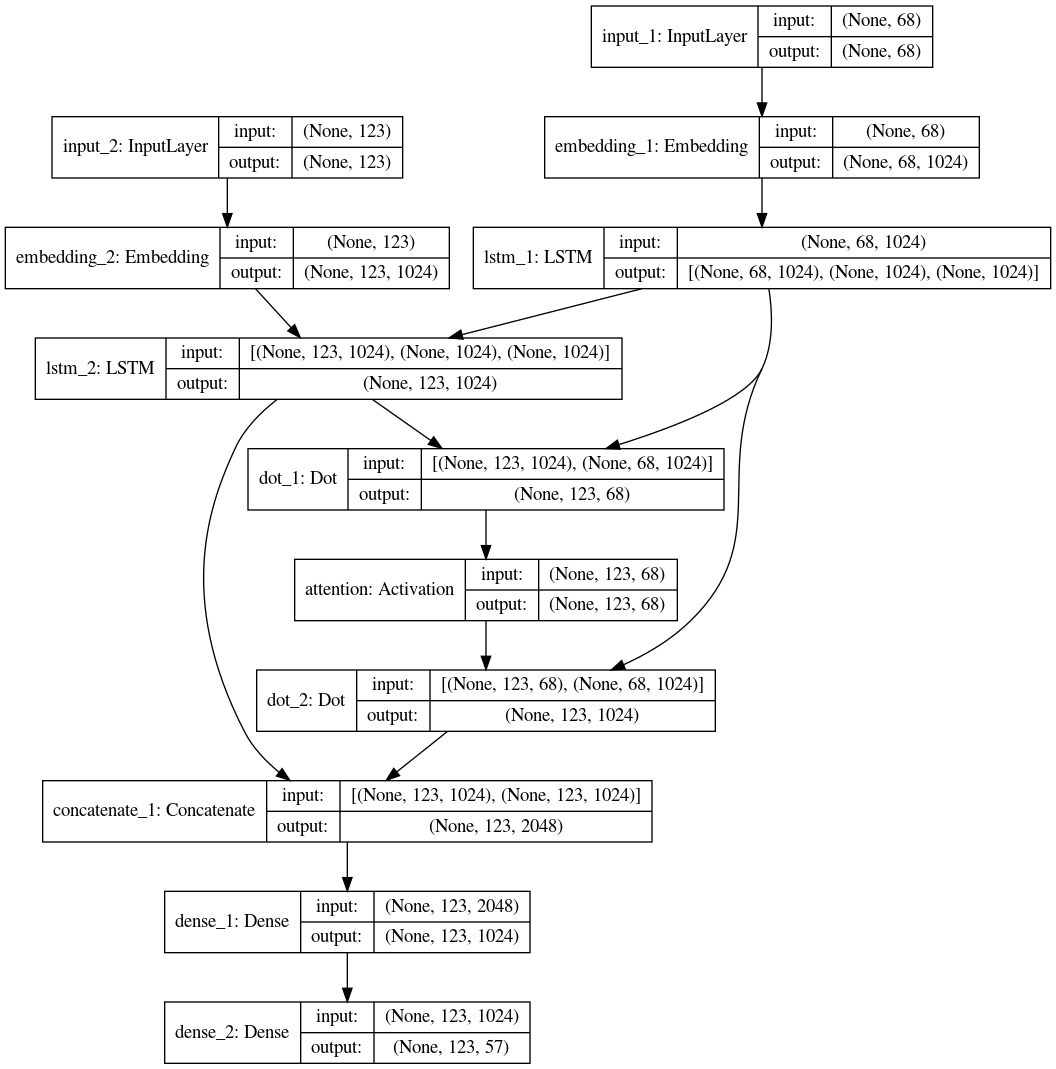

In [18]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

encoder_decoder = build_lstm_encoder_decoder(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(encoder_decoder, to_file='lstm_encoder_decoder.png', show_shapes=True, show_layer_names=True)
encoder_decoder.summary()
Image('lstm_encoder_decoder.png')

In [19]:
import datetime


epochs = 150
start_time = datetime.datetime.now().replace(microsecond=0)
encoder_decoder.fit([buggy_inputs, fixed_inputs], fixed_outputs, epochs=epochs)
end_time = datetime.datetime.now().replace(microsecond=0)

Epoch 1/150
5/5 [==============================] - 4s 771ms/step - loss: 4.0425
Epoch 2/150
5/5 [==============================] - 0s 64ms/step - loss: 3.6598
Epoch 3/150
5/5 [==============================] - 0s 59ms/step - loss: 11.6185
Epoch 4/150
5/5 [==============================] - 0s 63ms/step - loss: 8.1743
Epoch 5/150
5/5 [==============================] - 0s 61ms/step - loss: 6.4095
Epoch 6/150
5/5 [==============================] - 0s 62ms/step - loss: 7.2004
Epoch 7/150
5/5 [==============================] - 0s 61ms/step - loss: 6.4927
Epoch 8/150
5/5 [==============================] - 0s 62ms/step - loss: 6.4325
Epoch 9/150
5/5 [==============================] - 0s 60ms/step - loss: 5.1476
Epoch 10/150
5/5 [==============================] - 0s 61ms/step - loss: 4.6803
Epoch 11/150
5/5 [==============================] - 0s 58ms/step - loss: 4.4592
Epoch 12/150
5/5 [==============================] - 0s 63ms/step - loss: 4.3003
Epoch 13/150
5/5 [=============================

Epoch 104/150
5/5 [==============================] - 0s 61ms/step - loss: 2.6541
Epoch 105/150
5/5 [==============================] - 0s 59ms/step - loss: 2.7110
Epoch 106/150
5/5 [==============================] - 0s 61ms/step - loss: 2.4128
Epoch 107/150
5/5 [==============================] - 0s 62ms/step - loss: 2.1176
Epoch 108/150
5/5 [==============================] - 0s 59ms/step - loss: 1.9950
Epoch 109/150
5/5 [==============================] - 0s 62ms/step - loss: 1.9217
Epoch 110/150
5/5 [==============================] - 0s 61ms/step - loss: 1.9530
Epoch 111/150
5/5 [==============================] - 0s 59ms/step - loss: 1.9661
Epoch 112/150
5/5 [==============================] - 0s 61ms/step - loss: 2.2003
Epoch 113/150
5/5 [==============================] - 0s 62ms/step - loss: 2.5128
Epoch 114/150
5/5 [==============================] - 0s 62ms/step - loss: 2.3028
Epoch 115/150
5/5 [==============================] - 0s 62ms/step - loss: 1.7579
Epoch 116/150
5/5 [=========

In [20]:
print("Training took (h:mm:ss)", end_time-start_time)


def generate_fixed_ints(enc_dec, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<soc>"]
    for buggy, generated in tqdm(zip(bugs, gntd_ints), total=len(bugs)):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = enc_dec.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eoc>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints


def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

Training took (h:mm:ss) 0:00:51


In [21]:
generated_ints = generate_fixed_ints(encoder_decoder, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(buggy_codes, fixed_codes, generated_codes):
    print('Buggy code:', ''.join(buggy))
    print('Fixed code:', ''.join(fixed[1:-1]))
    print('Genration: ', ''.join(gnrtd[1:]))
    print('=============')

100%|██████████| 5/5 [00:31<00:00,  5.65s/it]

Buggy code: String toTest = "woordenboek_nederlands-3.1.1-sm+tb+fx+fn.xpi";
Fixed code: String toTest = "turkmen_spell_checker_dictionary-0.1.6-tb+fx+sm.xpi";
Genration:  String toTest = "turkmen_spell_checker_dictionary-0.1.6-tb+fx+sm.xpi";
Buggy code: || (this.collator != null && ! this.collator.equals(other.collator))
Fixed code: || (this.collator != null && ! this.collator.equals(other.collator) || (this.collator == null && other.collator != null))
Genration:  || (this.collator != null && ! this.collator.equals(other.collator == null && other.collator != null && other.collator != 
Buggy code: dest = _dpMgr.planDeployment(vmProfile, plan, exclude);
Fixed code: dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
Genration:  dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
Buggy code: LOG.info(clazz + " is not a valid POJO type");
Fixed code: LOG.info(clazz + " is not a valid POJO type because not all fields are valid POJO fields.");
Genration:  LOG.info(clazz +